# Built-in meshing functions

In this tutorial, we show how make simple meshes in CADDEE and how to visualize them. Currently, there is support for three kinds of meshes:

1. VLM mesh
2. 1-D beam nodal mesh
3. Rotor mesh: extracting quantities such as the thrust origin/vecetor and making discretizations of the blade. 

```{important}
In CADDEE, we distinguish between a meshes and a discretizations. 
- A discretization is a discrete representation of the geometric domain over which the numerical solution of a physics-based solver is defined
- A mesh is a set of discretizations. (If the set only contains one disretization, the two are equivalent)

For example, in VLM analysis, a VLM mesh can consist of multiple discretizations of lifting (or non-lifting) surfaces, e.g., the wing and the tail. In CADDEE, each discretization is stored in a parent `Mesh` class object.
```
```{important}
CADDEE's built-in meshing functions are intended to be helper functions that work reasonably well for relatively simple (wing) geometries. They are meant to automate the process of projecting points onto the outer mold line (OML). This allows changes to the geometry (e.g., during FFD) to be effectively propagated to physics-based solvers by re-evalutating meshes using the parametric coordinates and updated coefficients.

These helper functions work reasonably well for many (simple) geometries, e.g., for wings with no or moderate taper and relatively small curvature of the leading and trailing edge toward the wing. For more complicated geometries, they are not guaranteed to work. 
```

We use an OpenVSP model of the Cessna C172 as the central geometry for this tutorial. First, we import the geometry and make a wing component for the main wing and the tail.

To plot the geometry, we use the [Vedo](https://vedo.embl.es/) package, which allows for interactive plots. These plots are NOT wrapped within the Jupyter Notebook cells. Screenshots of the geometry and meshes, however, can be saved and embedded using the matplotlib library.


In [4]:
import CADDEE_alpha as cd
import csdl_alpha as csdl
from vedo import settings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

settings.default_backend = "vtk"

# Start the CSDL recorder
recorder = csdl.Recorder(inline=True, expand_ops=True)
recorder.start()

# import C172 geometry
c172_geom = cd.import_geometry("c172.stp", rotate_to_body_fixed_frame=False)
c172_geom.plot()

# Make aircraft component and pass in the geometry
aircraft = cd.aircraft.components.Aircraft(geometry=c172_geom, compute_surface_area=False)

# Make wing geometry from aircraft component and instantiate wing component
wing_geometry = aircraft.create_subgeometry(search_names=["MainWing"])
wing = cd.aircraft.components.Wing(AR=7.72, S_ref=16.23, taper_ratio=0.73, geometry=wing_geometry)

# Make horizontal tail geometry component
h_tail_geometry = aircraft.create_subgeometry(search_names=["HTail"])
h_tail = cd.aircraft.components.Wing(AR=3.83, S_ref=4.04, taper_ratio=0.60, geometry=h_tail_geometry)


Importing OpenVSP file: /home/marius/Desktop/packages/lsdo_lab/CADDEE_alpha/CADDEE_alpha/utils/../../examples/test_geometries/c172.stp


## VLM mesh
In this tutorial, the VLM mesh consists of a quad surface mesh/lattice of the wing and the tail. The main inputs to the `make_vlm_surface` helper function are 
- `wing_comp (Wing)`: instance of a wing component
- `num_spanwise (int)`: number of spanwise panels
- `num_chorwise (int)`: number of chordwise panels 
- `ignore_camber (bool)`: if true, the lattice will track the camber line by projecting onto the top and bottom surface of the wing and taking the avergage
- `spacing_spanwise (str)`: linear or cosine spacing of the panels in the spanwise direction
- `chordwise_spanwise (str)`: linear or cosine spacing of the panels in the chordwise direction

Please refer to the API reference or the function doc-string for any additional function inputs.

Overwriting/updating mesh wing_8_vlm_camber_mesh
Overwriting/updating mesh wing_9_vlm_camber_mesh
wing chord surface nocal coordinate
 [[[ 2.98021    -5.59658863  1.06278079]
  [ 2.9835539  -5.55578387  1.06133416]
  [ 2.99358374 -5.43396193  1.0572752 ]
  [ 3.01011813 -5.23290126  1.05046846]
  [ 3.03292772 -4.95553309  1.04107839]
  [ 3.06167991 -4.60590215  1.02924191]
  [ 3.09595541 -4.18910674  1.01513165]
  [ 3.13525443 -3.71122473  0.99895334]
  [ 3.17900362 -3.17922628  0.98085277]
  [ 3.22656581 -2.60086442  0.96136301]
  [ 3.27724665 -1.98457768  0.94049913]
  [ 3.33030736 -1.33935133  0.91865552]
  [ 3.3849742  -0.6745942   0.89615072]
  [ 3.44045    -0.00001     0.87331288]
  [ 3.3849742   0.6745942   0.89615072]
  [ 3.33030736  1.33935133  0.91865552]
  [ 3.27724665  1.98457768  0.94049913]
  [ 3.22656581  2.60086442  0.96136301]
  [ 3.17900362  3.17922628  0.98085277]
  [ 3.13525443  3.71122473  0.99895334]
  [ 3.09595541  4.18910674  1.01513165]
  [ 3.06167991  4.6059021

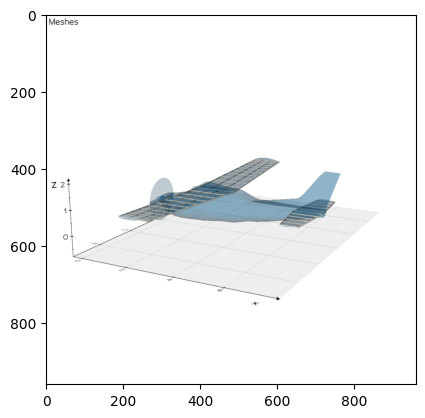

In [5]:
vlm_mesh = cd.mesh.VLMMesh()

# make wing lattice
wing_chord_surface = cd.mesh.make_vlm_surface(
    wing_comp=wing,
    num_chordwise=3,
    num_spanwise=26, # NOTE: must be even
    ignore_camber=True, # Creates a flat lattice instead of tracking the camber line
    spacing_spanwise="cosine", # bunch panels toward the wing tip
    plot=False, # plot the projections
)

# make tail lattice
h_tail_chord_surface = cd.mesh.make_vlm_surface(
    wing_comp=h_tail,
    num_chordwise=1,
    num_spanwise=10,
    ignore_camber=True,
    plot=True, # plot the projections
)

# Assign lattices to vlm mesh
vlm_mesh.discretizations["wing_vlm_lattice"] = wing_chord_surface
vlm_mesh.discretizations["h_tail_vlm_lattice"] = h_tail_chord_surface

# Extract the nodal coordinates
wing_chord_surface_nodal_coordinates = wing_chord_surface.nodal_coordinates.value
h_tail_chord_surface_nodal_coordinates = h_tail_chord_surface.nodal_coordinates.value
print("wing chord surface nocal coordinate\n", wing_chord_surface_nodal_coordinates)
print("h_tail chord surface nocal coordinate\n", h_tail_chord_surface_nodal_coordinates)

# Plot the VLM mesh
c172_geom.plot_meshes(
    meshes=[wing_chord_surface_nodal_coordinates, h_tail_chord_surface_nodal_coordinates],
    screenshot_file_name="vlm_mesh.png"
    )
plt.imshow(mpimg.imread("vlm_mesh.png"))



## 1-D Nodal (Box) Beam Mesh

The second tpype of mesh CADDEE has automated capabilities for is a box beam mesh, intended for beam analysis with rectangular cross-sections (not considering stringers). The main inputs to the `make_1d_box_beam` helper function are 
- `wing_comp (Wing)`: instance of a wing component
- `num_beam_nodes (int)`: number of beam nodes (must be odd)
- `norm_node_center (float)`: the normalized beam node center with respect to the leading edge (the beam height is computed at the node center)
- `norm_beam_width (float)`: the normalized beam width


Overwriting/updating mesh wing_2_1d_beam_mesh
Overwriting/updating mesh wing_box_beam
wing box beam nodal coordinates [[ 2.3705003  -5.59655377  1.07143593]
 [ 2.39350704 -5.03691174  1.05645777]
 [ 2.4165142  -4.47725266  1.04147759]
 [ 2.4395217  -3.91759351  1.02649586]
 [ 2.46252952 -3.35793438  1.01151275]
 [ 2.48553763 -2.79827526  0.99652837]
 [ 2.508546   -2.23861615  0.98154285]
 [ 2.53155462 -1.67895705  0.96655629]
 [ 2.55456345 -1.11929796  0.95156877]
 [ 2.57757248 -0.55963886  0.93658039]
 [ 2.60058171 -0.00001577  0.92159253]
 [ 2.57757248  0.55963886  0.93658039]
 [ 2.55456345  1.11929796  0.95156877]
 [ 2.53155462  1.67895705  0.96655629]
 [ 2.508546    2.23861615  0.98154285]
 [ 2.48553763  2.79827526  0.99652837]
 [ 2.46252952  3.35793438  1.01151275]
 [ 2.4395217   3.91759351  1.02649586]
 [ 2.4165142   4.47725266  1.04147759]
 [ 2.39350704  5.03691174  1.05645777]
 [ 2.3705003   5.59655377  1.07143593]]


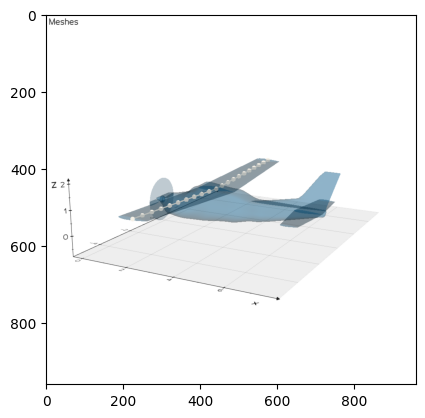

In [7]:
beam_mesh = cd.mesh.BeamMesh()

# Make box beam discretization
wing_box_beam = cd.mesh.make_1d_box_beam(
    wing_comp=wing,
    num_beam_nodes=21, # NOTE: must be odd such that one node is always at the wing root
    norm_node_center=0.5,
)

# Assign the box beam to the beam mesh object
beam_mesh.discretizations["wing_box_beam"] = wing_box_beam

# Extract the nodal coordinates
wing_box_beam_nodal_coordinates = wing_box_beam.nodal_coordinates.value
print("wing box beam nodal coordinates (x, y, z)\n", wing_box_beam_nodal_coordinates)

# Plot the mesh
c172_geom.plot_meshes(
    meshes=[wing_box_beam_nodal_coordinates],
    screenshot_file_name="beam_mesh.png"    
)
plt.imshow(mpimg.imread("beam_mesh.png"))
